To plot the final figures

In [57]:
import numpy as np
from scipy.spatial.distance import cdist # For calculating QPSK decoding
# import dill
from itertools import product, cycle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import tensorflow.keras.backend as K

In [58]:
# The one who steals the data
def robinhood(fig, filename=None, lineIdx=None):
    nAxis = len(fig.axes)
    print("nAxis = {}".format(nAxis))
    for _ax in fig.axes:
        nLines = len(_ax.lines)
        print("    nLines = {}".format(nLines))
        for _line in _ax.lines:
            print(_line.get_label(), "=>", _line.get_xdata().shape, ":", _line.get_ydata().shape)
    # fig.axes[0].lines[0]._label
# fig.axes[0].lines[0].get_label()/get_xdata()/get_ydata()
    

In [59]:
blkSize     = 4
chDim       = 2

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

one_hot_code = np.eye(inVecDim)

Traditional Methods

In [60]:
results_traditional = {}

In [61]:
qam_map = np.genfromtxt("./sphere_data/{:03d}x{:03d}_qam.csv".format(inVecDim,encDim))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

QAM Avg. Tx Power: 4.0
d_min: 2.0
En: 1.0


In [62]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0

  while thisErr < 500:
    txSym = np.random.randint(inVecDim, size=1000)
    txTest = qam_map[txSym]
    rxTest = txTest + np.random.normal(scale=np.sqrt(n0), size=txTest.shape)
    rxDecode = cdist(rxTest, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)

results_traditional["QAM"] = {
    "en": qam_en,
    "dmin": qam_d_min,
    "sym_pow": qam_sym_pow,
    "bler": np.array(err)
}

In [63]:
agrell_map = np.genfromtxt("./sphere_data/{:03d}x{:03d}_agrell.csv".format(inVecDim,encDim))
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "QAM Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

agrell_d_min = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_d_min )

agrell_en = agrell_sym_pow / (agrell_d_min**2)
print("En:", agrell_en)

QAM Avg. Tx Power: 3.095200273238941
d_min: 1.9999999999999998
En: 0.7738000683097355


In [64]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  
  while thisErr < 500:
    txSym = np.random.randint(inVecDim, size=1000)
    txTest = agrell_map[txSym]
    rxTest = txTest + np.random.normal(scale=np.sqrt(n0), size=txTest.shape)
    rxDecode = cdist(rxTest, agrell_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)

results_traditional["Agrell"] = {
    "en": agrell_en,
    "d_min": agrell_d_min,
    "sym_pow": agrell_sym_pow,
    "bler": np.array(err)
}

Deep Learning models

In [65]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "[4]": "./models_08x04/awgn_oshea_64_32_16_10dB_summary.h5",
        "Proposed: Trained with (19)": "./models_08x04/awgn_awgn_64_32_16_n080_summary.h5",
        "Proposed: Trained with (26)": "./models_08x04/awgn_rbf_64_32_16_n080_summary.h5",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/08x04/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/08x04/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/08x04/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/08x04/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/08x04/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/08x04/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        # For PPT
        "Oshe'a2017": "./models_04x02/awgn_oshea_04x02_64_32_16_10dB_summary.h5",
        "Proposed: AWGN Objective": "./models_04x02/awgn_awgn_04x02_64_32_16_n040_summary.h5",
        "Proposed: RBF Objective": "./models_04x02/awgn_rbf_04x02_64_32_16_n040_summary.h5",
#         "[4]": "./models_04x02/awgn_oshea_04x02_64_32_16_10dB_summary.h5",
#         "Proposed: Trained with (19)": "./models_04x02/awgn_awgn_04x02_64_32_16_n040_summary.h5",
#         "Proposed: Trained with (26)": "./models_04x02/awgn_rbf_04x02_64_32_16_n040_summary.h5",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/04x02/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/04x02/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/04x02/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/04x02/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/04x02/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/04x02/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        # For PPT
        "Oshe'a2017": "./models_02x01/awgn_oshea_02x01_64_32_16_10dB_summary.h5",
        "Proposed: AWGN Objective": "./models_02x01/awgn_awgn_02x01_64_32_16_n020_summary.h5",
        "Proposed: RBF Objective": "./models_02x01/awgn_rbf_02x01_64_32_16_n020_summary.h5",
#         "[4]": "./models_02x01/awgn_oshea_02x01_64_32_16_10dB_summary.h5",
#         "Proposed: Trained with (19)": "./models_02x01/awgn_awgn_02x01_64_32_16_n020_summary.h5",
#         "Proposed: Trained with (26)": "./models_02x01/awgn_rbf_02x01_64_32_16_n020_summary.h5",
        
#         "(19) with $\sigma_0^2 = 0.10$": "./models/02x01/sigma2_010/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.10$": "./models/02x01/sigma2_010/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 0.50$": "./models/02x01/sigma2_050/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 0.50$": "./models/02x01/sigma2_050/awgn_rbf_64_32_16_n080_summary.dil",
        
#         "(19) with $\sigma_0^2 = 1.50$": "./models/02x01/sigma2_150/awgn_awgn_64_32_16_n080_summary.dil",
#         "(23) with $\sigma_0^2 = 1.50$": "./models/02x01/sigma2_150/awgn_rbf_64_32_16_n080_summary.dil"
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [66]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

Oshe'a2017                                  ./models_04x02/awgn_oshea_04x02_64_32_16_10dB_summary.h5              EXISTS
Proposed: AWGN Objective                    ./models_04x02/awgn_awgn_04x02_64_32_16_n040_summary.h5               EXISTS
Proposed: RBF Objective                     ./models_04x02/awgn_rbf_04x02_64_32_16_n040_summary.h5                EXISTS


Load the results from summary files

In [67]:
for (label, summary_file) in model_summary.items():
    results[label] = pd.read_hdf(summary_file, 'table')

Plot the results: Packing Density

nAxis = 1
    nLines = 5
QAM => (2,) : (2,)
Agrell => (2,) : (2,)
Oshe'a2017 => (128,) : (128,)
Proposed: AWGN Objective => (128,) : (128,)
Proposed: RBF Objective => (128,) : (128,)


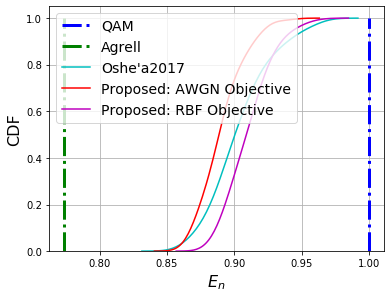

In [68]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

# Plot lines for traditional methods
plt.plot(2*[results_traditional["QAM"]["en"]], [0,1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
# plt.plot(2*[results_traditional["Agrell"]["en"]], [0,1], linewidth=3, label="Agrell [17]", color=next(colors), linestyle="-.")
plt.plot(2*[results_traditional["Agrell"]["en"]], [0,1], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    clr = next(colors)
    sns.distplot(result["en"], label=label, color=clr,
                 bins=100,
                 rug=False, 
                 
                 kde=True, 
                 kde_kws=dict(cumulative=True, 
                              linestyle=":" if "Oshea" in label or "[1]" in label else "-"),
                 
                 hist=False,
                 hist_kws=dict(cumulative=True, 
                               density=True, 
                               histtype="step", 
                               linestyle=":" if "Oshea" in label or "[1]" in label else "-",
                               linewidth=2,
                               color=clr, alpha=1.0))

# Experiment specific axis limits
if blkSize==8 and chDim==4:
    plt.xlim([0.95*results_traditional["Agrell"]["en"], 2.5*results_traditional["Agrell"]["en"]])
elif blkSize==4 and chDim==2:
    pass
elif blkSize==2 and chDim==1:
    pass
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
plt.grid()
plt.legend(loc='upper left', prop={'size':14})
plt.savefig("output_awgn_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
# fig.axes[0].lines[0]._label
# fig.axes[0].lines[0].get_label()/get_xdata()/get_ydata()
robinhood(fig)

Plot results: BLER

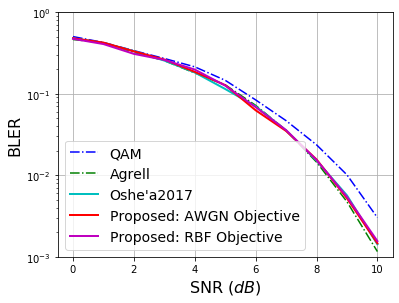

In [69]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

plt.semilogy(SNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
# plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell [17]", color=next(colors), linestyle="-.")
plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    best_model_id = result['en'].idxmin()  # Find the model with best E_n
    plt.semilogy(SNR_range_dB, 
                 result.loc[best_model_id]["bler"], 
                 label=label, color=next(colors), linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-3,1e0))
plt.savefig("output_awgn_best_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')

Plot results: BLER with confidence

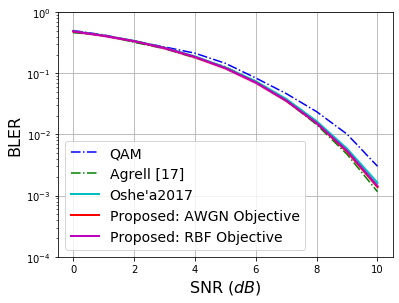

In [70]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

plt.semilogy(SNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell [17]", color=next(colors), linestyle="-.")

for (label, result) in results.items():
    clr = next(colors)
    bler_mean = result["bler"].mean()
    bler_std  = np.array(result['bler']).std()
    plt.fill_between(SNR_range_dB, bler_mean+bler_std, bler_mean-bler_std, alpha=0.1, color=clr)
    
    plt.semilogy(SNR_range_dB, 
                 result["bler"].mean(), 
                 label=label, color=clr, linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-4,1e0))
plt.savefig("output_awgn_avg_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')